# Deep Learning prediction of pneumonia from chest X-ray images

## Importing the libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow import keras
from PIL import Image
from matplotlib import image
import cv2
from tqdm import tqdm
from sklearn.metrics import *

from sklearn.metrics import classification_report, confusion_matrix
from keras import backend as keras
from keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import load_model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.layers import Conv2DTranspose
from tensorflow.keras.optimizers import Adam

from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras_preprocessing.image import load_img, img_to_array
#from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from glob import glob

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

## Loading the Data

In [2]:
IMAGE_SIZE = [224, 224]

train_path = 'chest_xray/train'
valid_path = 'chest_xray/test'

## Preview of the Images

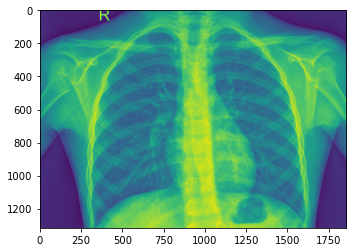

In [3]:
image_normal=image.imread('chest_xray/test/NORMAL/IM-0001-0001.jpeg')
plt.imshow(image_normal)

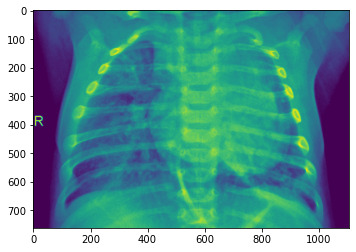

In [4]:
image_pneumonia=image.imread('chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg')
plt.imshow(image_pneumonia)

### Preprocessing the Images

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)




# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 10,
                                                 class_mode = 'categorical')




test_set = test_datagen.flow_from_directory('chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 10,
                                            class_mode = 'categorical')


validation_set = test_datagen.flow_from_directory('chest_xray/val',
                                            target_size = (224, 224),
                                            batch_size = 10,
                                            class_mode = 'categorical')
                                            

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### 1. Decision Tree

In [6]:
# Input data files are available in the "../input/" directory.
INPUT_PATH = "chest_xray"

# List the files in the input directory.
print(os.listdir(INPUT_PATH))

['.DS_Store', 'test', 'train', 'val']


In [8]:
from pathlib import Path
train_normal = Path(INPUT_PATH + '/train/NORMAL').glob('*.jpeg')
train_pneumonia = Path(INPUT_PATH + '/train/PNEUMONIA').glob('*.jpeg')

normal_data = [(image, 0) for image in train_normal]
pneumonia_data = [(image, 1) for image in train_pneumonia]

train_data = normal_data + pneumonia_data

train_data = pd.DataFrame(train_data, columns=['image', 'label'])

train_data.head()

,image,label
0,chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg,0
1,chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg,0
2,chest_xray/train/NORMAL/IM-0427-0001.jpeg,0
3,chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg,0
4,chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg,0


In [9]:
def data_input(dataset):
    for image in dataset:
        im = cv2.imread(str(image))
        im = cv2.resize(im, (224,224))
        if im.shape[2] == 1:
            im = np.dstack([im, im, im])
        x_image = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        x_image = x_image.astype(np.float32)/255.
        return x_image

In [10]:
def load_data(files_dir='/train'):
    # list of the paths of all the image files
    normal = Path(INPUT_PATH + files_dir + '/NORMAL').glob('*.jpeg')
    pneumonia = Path(INPUT_PATH + files_dir + '/PNEUMONIA').glob('*.jpeg')

    # --------------------------------------------------------------
    # Data-paths' format in (img_path, label) 
    # labels : for [ Normal cases = 0 ] & [ Pneumonia cases = 1 ]
    # --------------------------------------------------------------
    normal_data = [(image, 0) for image in normal]
    pneumonia_data = [(image, 1) for image in pneumonia]

    image_data = normal_data + pneumonia_data

    # Get a pandas dataframe for the data paths 
    image_data = pd.DataFrame(image_data, columns=['image', 'label'])
    
    # Shuffle the data 
    image_data = image_data.sample(frac=1., random_state=100).reset_index(drop=True)
    
    # Importing both image & label datasets...
    x_images, y_labels = ([data_input(image_data.iloc[i][:]) for i in range(len(image_data))], 
                         [image_data.iloc[i][1] for i in range(len(image_data))])

    # Convert the list into numpy arrays
    x_images = np.array(x_images)
    x_images = x_images.reshape(x_images.shape[0],x_images.shape[1]*x_images.shape[2]*x_images.shape[3])
    y_labels = np.array(y_labels)
    
    print("Total number of images: ", x_images.shape)
    print("Total number of labels: ", y_labels.shape)
    
    return x_images, y_labels

In [11]:
x_train, y_train = load_data(files_dir='/train')

print(x_train.shape)
print(y_train.shape)

Total number of images:  (5216, 150528)
Total number of labels:  (5216,)
(5216, 150528)
(5216,)


In [12]:
x_test, y_test = load_data(files_dir='/test')
print(x_test.shape)
print(y_test.shape)


Total number of images:  (624, 150528)
Total number of labels:  (624,)
(624, 150528)
(624,)


In [13]:
x_val, y_val = load_data(files_dir='/val')

print(x_val.shape)
print(y_val.shape)

Total number of images:  (16, 150528)
Total number of labels:  (16,)
(16, 150528)
(16,)


In [14]:
# using decision tree to classify the images
from sklearn.tree import DecisionTreeClassifier

# create the classifier
classifier = DecisionTreeClassifier()

# fit the classifier to the training data
classifier.fit(x_train, y_train)

# predict the labels of new data (new images)
y_pred = classifier.predict(x_test)


In [18]:
# evaluate the model
# print the accuracy
print("Accuracy:",accuracy_score(y_test, y_pred))

# print the confusion matrix
print("\nConfusion Matrix: \n",confusion_matrix(y_test, y_pred))

# print the classification report
print("\nClassification Report: ",classification_report(y_test, y_pred))


Accuracy: 0.7339743589743589

Confusion Matrix: 
 [[ 87 147]
 [ 19 371]]

Classification Report:                precision    recall  f1-score   support

           0       0.82      0.37      0.51       234
           1       0.72      0.95      0.82       390

    accuracy                           0.73       624
   macro avg       0.77      0.66      0.66       624
weighted avg       0.76      0.73      0.70       624



### 2. Random Forest

In [19]:
# using random forest to classify the images
from sklearn.ensemble import RandomForestClassifier

# create the classifier
Rdfclassifier = RandomForestClassifier()

# fit the classifier to the training data
Rdfclassifier.fit(x_train, y_train)

# predict the labels of new data (new images)
y_pred_rdf = Rdfclassifier.predict(x_test)


In [22]:
# Evaluate the Random Forest model
# print the accuracy
print("Accuracy:",accuracy_score(y_test, y_pred_rdf))

# print the confusion matrix
print("\nConfusion Matrix:\n ",confusion_matrix(y_test, y_pred_rdf))

# print the classification report
print("\nClassification Report: ",classification_report(y_test, y_pred_rdf))

Accuracy: 0.7548076923076923

Confusion Matrix:
  [[ 83 151]
 [  2 388]]

Classification Report:                precision    recall  f1-score   support

           0       0.98      0.35      0.52       234
           1       0.72      0.99      0.84       390

    accuracy                           0.75       624
   macro avg       0.85      0.67      0.68       624
weighted avg       0.82      0.75      0.72       624



### 3.The VGG16 Model 

1. We're using the VGG16 model, which is a pre-trained model that has been trained on the ImageNet dataset.

2. We're using the imagenet weights, which means that we're using the weights that VGG16 has already learned.

3. We're excluding the top layer, which is the layer that is used for classification.

In [6]:
# instantiate the model with imagenet weights and without the top layer
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# making sure not to train existing weights
for layer in vgg.layers:
    layer.trainable = False

folders = glob('chest_xray/train/*')
x = Flatten()(vgg.output)


def create_model():
    prediction = Dense(len(folders), activation='softmax')(x)
    model = Model(inputs=vgg.input, outputs=prediction)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

create_model().summary()

model = create_model()

model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=1,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  shuffle=True,
  verbose=1,
)

2022-11-29 10:29:04.969302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Evaluating the Model performance

In [8]:
from sklearn.metrics import *

In [11]:
def Evaluation(model, test_set):
    # Predict the values from the validation dataset
    Y_pred = model.predict_generator(test_set, len(test_set))
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = test_set.classes
    # print accuracy score
    print('Accuracy Score: ', accuracy_score(Y_true, Y_pred_classes))
    # print the confusion matrix
    print("Confusion Matrix: \n",confusion_matrix(Y_true, Y_pred_classes))
    # print classification report
    print("Classification Report: \n",classification_report(Y_true, Y_pred_classes, target_names = test_set.class_indices.keys()))
    
    
Evaluation(model, test_set)

Accuracy Score:  0.5705128205128205
Confusion Matrix: 
 [[ 66 168]
 [100 290]]
Classification Report: 
               precision    recall  f1-score   support

      NORMAL       0.40      0.28      0.33       234
   PNEUMONIA       0.63      0.74      0.68       390

    accuracy                           0.57       624
   macro avg       0.52      0.51      0.51       624
weighted avg       0.54      0.57      0.55       624



The model is not yet performing well with an accuracy of 57% . We can try to improve the model by using data augmentation and fine-tuning the model.

### Saving the Model

In [13]:
def saving_model(model, model_name):
    model.save(model_name)
    print("Model saved as " + model_name)

saving_model(model, 'VGG16model.h5')

Model saved as VGG16model.h5


In [14]:
def loading_model(model_name):
    model = load_model(model_name)
    print("Model loaded from " + model_name)
    return model

model2 = loading_model('VGG16model.h5')

Model loaded from VGG16model.h5


#### Loading the Model and Testing it on Validation Data

In [16]:
def predict_pneumonia(img,model_name):
    # load the model
    model = load_model(model_name)
    # load and prepare the image
    img = load_img(img,target_size=(224,224))
    # convert to array
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    # preprocess the image
    img_data=preprocess_input(x)
    # predict the class
    classes=model.predict(img_data)
    result=int(classes[0][0])
    if result==0:
        print("Person is Affected By PNEUMONIA")
        plt.imshow(load_img('chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg',target_size=(224,224)))
    else:
        print("Person Results are Normal")
        plt.imshow(load_img('chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg',target_size=(224,224)))

1/1 [==============================] - 1s 611ms/step
Person Results are Normal


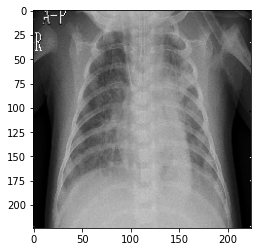

In [19]:
predict_pneumonia('chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg', model_name='VGG16model.h5')

The model was able to predict the absence of pneumonia in the chest X-ray image of the validation data

1/1 [==============================] - 1s 600ms/step
Person is Affected By PNEUMONIA


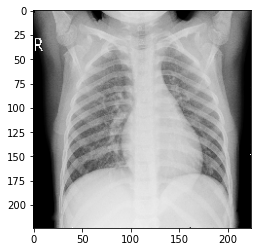

In [20]:
predict_pneumonia('chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg', model_name='VGG16model.h5')

The model was able to identify the pneumonia in the chest X-ray image of the validation data

### 4. ResNet50 Model

In [33]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [34]:
# creating an Resnet model to classify the image into pneumonia or normal
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# create the base pre-trained model
base_model = ResNet50(input_shape=IMAGE_SIZE + [3],weights='imagenet', include_top=False)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# and a logistic layer 
prediction1 = Dense(len(folders), activation='softmax')(x)

# this is the model we will train
model1 = Model(inputs=base_model.input, outputs=prediction1)

model1.summary()

# compile the model (should be done *after* setting layers to non-trainable)
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model1.fit_generator(
    training_set,
    validation_data=test_set,
    epochs=1,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set),
    shuffle=True,
    verbose=1
)


94765736/94765736 [==============================] - 394s 4us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                         

In [37]:
Evaluation(model1, test_set)

Accuracy Score:  0.6185897435897436
Confusion Matrix: 
 [[ 19 215]
 [ 23 367]]
Classification Report: 
               precision    recall  f1-score   support

      NORMAL       0.45      0.08      0.14       234
   PNEUMONIA       0.63      0.94      0.76       390

    accuracy                           0.62       624
   macro avg       0.54      0.51      0.45       624
weighted avg       0.56      0.62      0.52       624



In [38]:
saving_model(model1, 'Resnetmodel.h5')

Model saved as Resnetmodel.h5


In [39]:
loading_model('Resnetmodel.h5')

Model loaded from Resnetmodel.h5


1/1 [==============================] - 4s 4s/step
Person is Affected By PNEUMONIA


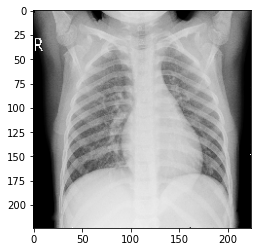

In [50]:
predict_pneumonia('chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg', model_name='Resnetmodel.h5')

The ResNet50 model classified this person as having pneumonia ,however, the person does not have pneumonia.

1/1 [==============================] - 1s 1s/step
Person is Affected By PNEUMONIA


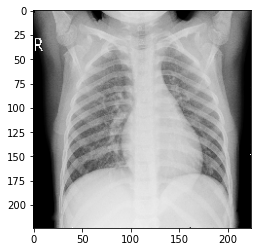

In [51]:
predict_pneumonia('chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg', model_name='Resnetmodel.h5')

The ResNet50 model classified this person as having pneumonia and the person does have pneumonia.

### 5. InceptionV3 Model

In [22]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model2 = InceptionV3(input_shape=IMAGE_SIZE + [3], include_top = False, weights = 'imagenet')

# don't train existing weights
for layer in base_model2.layers:
    layer.trainable = False

# useful for getting number of output classes
folders = glob('chest_xray/train/*')

# our layers - you can add more if you want
x = Flatten()(base_model2.output)

prediction2 = Dense(len(folders), activation='softmax')(x)

# create a model object
model2 = Model(inputs=base_model2.input, outputs=prediction2)

# view the structure of the model
model2.summary()

# tell the model what cost and optimization method to use
model2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# fit the model
# Run the cell. It will take some time to execute
model2.fit_generator(
    training_set,
    validation_data=test_set,
    epochs=1,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set),
    shuffle=True,
    verbose=1
)

87910968/87910968 [==============================] - 362s 4us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)              

In [29]:
Evaluation(model2, test_set)

Accuracy Score:  0.5496794871794872
Confusion Matrix: 
 [[ 87 147]
 [134 256]]
Classification Report: 
               precision    recall  f1-score   support

      NORMAL       0.39      0.37      0.38       234
   PNEUMONIA       0.64      0.66      0.65       390

    accuracy                           0.55       624
   macro avg       0.51      0.51      0.51       624
weighted avg       0.54      0.55      0.55       624



In [25]:
saving_model(model2, 'Inceptionmodel.h5')

Model saved as Inceptionmodel.h5


In [26]:
model4 = loading_model('Inceptionmodel.h5')

Model loaded from Inceptionmodel.h5


1/1 [==============================] - 4s 4s/step
Person is Affected By PNEUMONIA


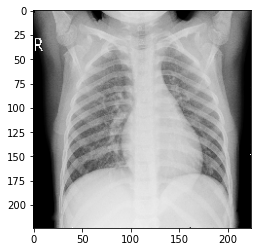

In [27]:
predict_pneumonia('chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg', model_name='Inceptionmodel.h5')

The InceptionV3 model classified this person as having pneumonia ,however, the person does not have pneumonia.

1/1 [==============================] - 7s 7s/step
Person is Affected By PNEUMONIA


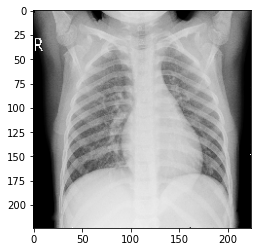

In [28]:
predict_pneumonia('chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg', model_name='Inceptionmodel.h5')

The InceptionV3 model classified this person as having pneumonia and the person does have pneumonia.

### Conclusion

1. Out of the three deep learning models, the ResNet50 model performed the best with an accuracy of 62% though this a very good accuracy, it can be improved by using data augmentation and fine-tuning the model.<br><br>
2. The VGG16 model required the most computational time of 55 minutes followed by the ResNet50 with 25 minutes and finally InceptionV3 with 18 minutes <br><br>
3. The ResNet50 model was used on the interface to predict the presence of pneumonia in the chest X-ray image 

### Recommendation

1. The model can be improved by using data augmentation and fine-tuning the model.<br><br>